## Pre-processing

### Compression of Images to compensate for limited resources available

In [14]:
import os
import cv2
import numpy as np
from PIL import Image

In [15]:
# Define input and output folder paths
input_folder = './images'  # Folder containing the images
output_folder = 'compressed_images'  # Folder to save compressed images
os.makedirs(output_folder, exist_ok=True)  # Create output folder if it doesn't exist

In [16]:
# Define compression factors (you can adjust these if needed)
downscale_factor = 0.3  # Resize image to 30% of the original size
compression_quality = 30  # JPEG quality (lower means more compression)

# Supported image formats (JPEG, JPG, PNG, etc.)
supported_formats = ['.jpg', '.jpeg', '.png']

In [17]:
# Function to process and compress a single image
def process_image(input_image_path, output_image_path):
    # Load the image using OpenCV
    image = cv2.imread(input_image_path)

    # Convert the image to grayscale to reduce file size and enhance text
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)

    # Downscale the image to the specified percentage of the original size
    new_width = int(enhanced_image.shape[1] * downscale_factor)
    new_height = int(enhanced_image.shape[0] * downscale_factor)
    resized_image = cv2.resize(enhanced_image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Save the compressed image with enhanced contrast
    cv2.imwrite(output_image_path, resized_image, [int(cv2.IMWRITE_JPEG_QUALITY), compression_quality])

In [18]:
# Iterate over all files in the input folder
for filename in os.listdir(input_folder):
    # Check if the file is an image by verifying its extension
    if any(filename.lower().endswith(ext) for ext in supported_formats):
        input_image_path = os.path.join(input_folder, filename)  # Full input path
        output_image_path = os.path.join(output_folder, filename)  # Full output path
        
        # Process and compress the image
        process_image(input_image_path, output_image_path)

        print(f"Compressed and enhanced image saved to: {output_image_path}")

print("Processing complete for all images in the folder.")

Compressed and enhanced image saved to: compressed_images/dupickens_a-1_011.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_013.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_015.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_016.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_017.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_023.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_024.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_025.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_026.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_027.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_028.jpg
Compressed and enhanced image saved to: compressed_images/dupickens_a-1_029.jpg
Compressed and enhanced image saved to: 

### Conversion of Images to Binary Adaptive, Binary Otsu, Enhanced, Original Compressed Formats using Tesseract OCR

In [1]:
import os
import cv2
import numpy as np
import pytesseract
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import json
import time
from datetime import datetime

def save_results_to_file(results, output_dir, timestamp):
    """Save results directly to files without using pandas"""
    # Save detailed JSON results
    json_path = os.path.join(output_dir, f"detailed_results_{timestamp}.json")
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=4)
    
    csv_path = os.path.join(output_dir, f"summary_{timestamp}.csv")
    with open(csv_path, 'w') as f:
        f.write("filename,status,text_length,best_method\n")
        # Write data
        for r in results:
            text_length = len(r['text']) if r['status'] == 'success' and 'text' in r else 0
            best_method = r.get('best_method', '')
            f.write(f"{r['filename']},{r['status']},{text_length},{best_method}\n")
            
class EnhancedOCR:
    def __init__(self, input_folder, output_folder, num_threads=4):
        """Initialize OCR processor"""
        self.input_folder = input_folder
        self.output_folder = output_folder
        self.num_threads = num_threads
        self.create_output_dirs()

    def create_output_dirs(self):
        """Create output directory structure"""
        self.processed_dir = os.path.join(self.output_folder, 'processed_images')
        self.results_dir = os.path.join(self.output_folder, 'results')
        os.makedirs(self.processed_dir, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)

    def enhance_image(self, image):
        """Advanced image preprocessing pipeline"""
        try:
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()

            max_dim = 2000
            height, width = gray.shape
            if max(height, width) > max_dim:
                scale = max_dim / max(height, width)
                gray = cv2.resize(gray, None, fx=scale, fy=scale)

            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            enhanced = clahe.apply(gray)

            denoised = cv2.fastNlMeansDenoising(enhanced)

            binary_adaptive = cv2.adaptiveThreshold(
                denoised, 255, 
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                cv2.THRESH_BINARY, 11, 2
            )

            _, binary_otsu = cv2.threshold(
                denoised, 0, 255, 
                cv2.THRESH_BINARY + cv2.THRESH_OTSU
            )

            return {
                'original': gray,
                'enhanced': enhanced,
                'binary_adaptive': binary_adaptive,
                'binary_otsu': binary_otsu
            }
        except Exception as e:
            print(f"Error in image enhancement: {str(e)}")
            return None

    def extract_text(self, image_dict):
        """Extract text using different preprocessing variants"""
        results = {}
        custom_config = r'--oem 3 --psm 6'
        
        for img_type, img in image_dict.items():
            try:
                text = pytesseract.image_to_string(img, config=custom_config)
                results[img_type] = text.strip()
            except Exception as e:
                results[img_type] = f"Error: {str(e)}"
                
        return results

    def process_single_image(self, image_file):
        """Process a single image for preprocessing only."""
        try:
            image_path = os.path.join(self.input_folder, image_file)
            image = cv2.imread(image_path)
            
            if image is None:
                return {
                    'filename': image_file,
                    'status': 'error',
                    'error': 'Failed to load image'
                }

            enhanced_images = self.enhance_image(image)
            if enhanced_images is None:
                return {
                    'filename': image_file,
                    'status': 'error',
                    'error': 'Failed to enhance image'
                }

            # Save the preprocessed images
            for img_type, img in enhanced_images.items():
                output_path = os.path.join(
                    self.processed_dir,
                    f"{os.path.splitext(image_file)[0]}_{img_type}.png"
                )
                cv2.imwrite(output_path, img)

            return {
                'filename': image_file,
                'status': 'success',
                'processed_images': list(enhanced_images.keys())
            }

        except Exception as e:
            return {
                'filename': image_file,
                'status': 'error',
                'error': str(e)
            }


    def process_all_images(self):
        """Process all images using thread pool"""
        start_time = time.time()
        
        image_files = [f for f in os.listdir(self.input_folder) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff'))]
        
        results = []
        with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
            futures = {
                executor.submit(self.process_single_image, image_file): image_file 
                for image_file in image_files
            }
            
            with tqdm(total=len(image_files), desc="Processing images") as pbar:
                for future in as_completed(futures):
                    result = future.result()
                    results.append(result)
                    pbar.update(1)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        save_results_to_file(results, self.results_dir, timestamp)

        processing_time = time.time() - start_time
        stats = {
            'total_images': len(image_files),
            'successful': len([r for r in results if r['status'] == 'success']),
            'failed': len([r for r in results if r['status'] == 'error']),
            'processing_time': processing_time,
            'average_time_per_image': processing_time / len(image_files)
        }

        stats_path = os.path.join(self.results_dir, f"processing_stats_{timestamp}.json")
        with open(stats_path, 'w') as f:
            json.dump(stats, f, indent=4)

        return stats, results
    
input_folder = "images"
output_folder = "output"

ocr = EnhancedOCR(input_folder, output_folder, num_threads=4)
stats, results = ocr.process_all_images()

print("\nProcessing Summary:")
print(f"Total images processed: {stats['total_images']}")
print(f"Successful: {stats['successful']}")
print(f"Failed: {stats['failed']}")
print(f"Total processing time: {stats['processing_time']:.2f} seconds")
print(f"Average time per image: {stats['average_time_per_image']:.2f} seconds")

Processing images: 100%|██████████| 427/427 [09:37<00:00,  1.35s/it]


Processing Summary:
Total images processed: 427
Successful: 427
Failed: 0
Total processing time: 577.73 seconds
Average time per image: 1.35 seconds


## EDA

In [ ]:
# pip install pandas
# pip install seaborn

In [ ]:
import os
import pandas as pd
from PIL import Image

# List all image files
image_folder = "images"
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Extract metadata from filenames
image_data = []
for file in image_files:
    parts = file.split('_')
    unit_id = parts[0]
    sequence_id = parts[2].split('.')[0]
    image_data.append((file, unit_id, sequence_id))

# Create DataFrame and check for missing IDs
df_images = pd.DataFrame(image_data, columns=['filename', 'unit_id', 'sequence_id'])
df_images['sequence_id'] = pd.to_numeric(df_images['sequence_id'], errors='coerce')
full_range = set(range(11, 445))
present_ids = set(df_images['sequence_id'])
missing_ids = full_range - present_ids

# Summary
print(f"Total Images: {len(df_images)}")
print(f"Unique Images: {df_images['sequence_id'].nunique()}")
print(f"Missing Sequence IDs: {sorted(missing_ids)}")

Total Images: 427
Unique Images: 427
Missing Sequence IDs: [12, 14, 18, 19, 20, 21, 22]


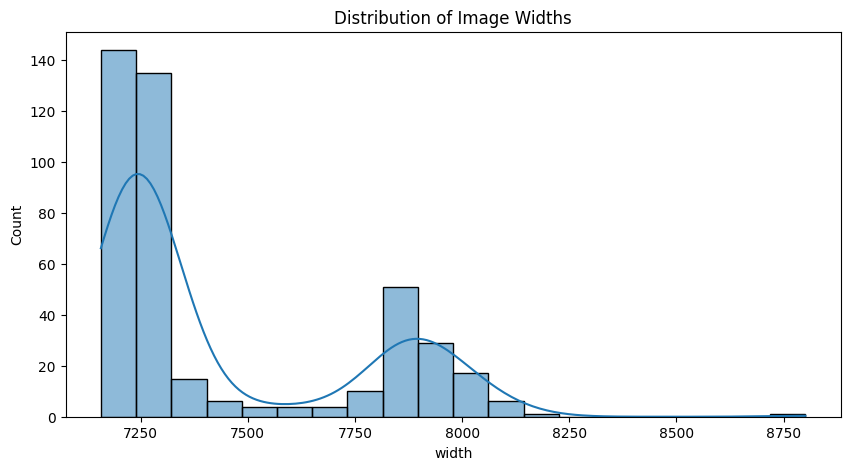

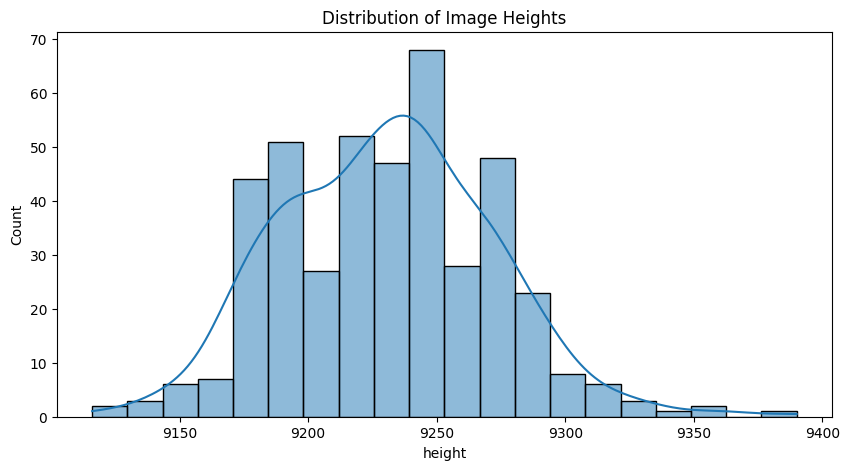

In [ ]:
# Analyze image sizes
image_sizes = []
for file in df_images['filename']:
    with Image.open(os.path.join(image_folder, file)) as img:
        image_sizes.append(img.size)

df_images['width'], df_images['height'] = zip(*image_sizes)

# Plot distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df_images['width'], bins=20, kde=True)
plt.title('Distribution of Image Widths')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_images['height'], bins=20, kde=True)
plt.title('Distribution of Image Heights')
plt.show()


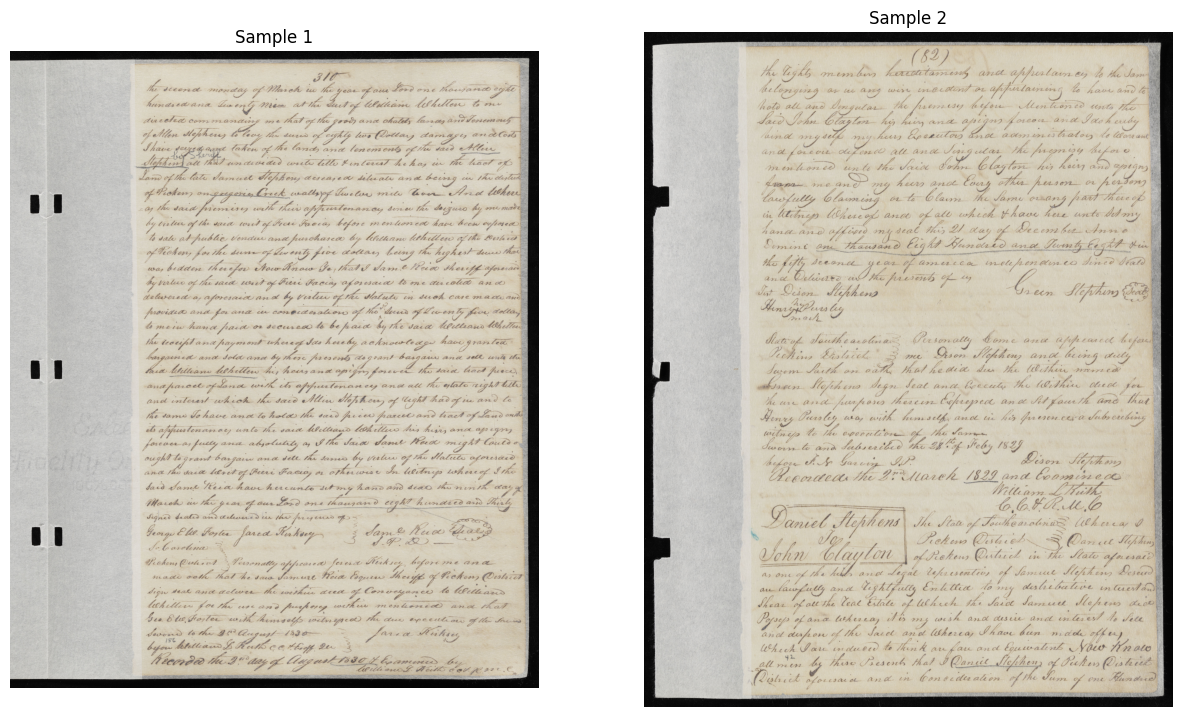

In [ ]:
# Analyze image sizes
image_sizes = []
for file in df_images['filename']:
    with Image.open(os.path.join(image_folder, file)) as img:
        image_sizes.append(img.size)

df_images['width'], df_images['height'] = zip(*image_sizes)

import matplotlib.pyplot as plt
from PIL import Image

# Display random samples of images
sample_files = df_images['filename'].sample(2)
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
for i, file in enumerate(sample_files):
    img = Image.open(os.path.join(image_folder, file))
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis('off')
plt.show()

In [ ]:
# List all image files
image_folder = "compressed_images"
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Extract metadata from filenames
image_data = []
for file in image_files:
    parts = file.split('_')
    unit_id = parts[0]
    sequence_id = parts[2].split('.')[0]
    image_data.append((file, unit_id, sequence_id))

# Create DataFrame and check for missing IDs
df_images = pd.DataFrame(image_data, columns=['filename', 'unit_id', 'sequence_id'])
df_images['sequence_id'] = pd.to_numeric(df_images['sequence_id'], errors='coerce')

# Analyze image sizes
image_sizes = []
for file in df_images['filename']:
    with Image.open(os.path.join(image_folder, file)) as img:
        image_sizes.append(img.size)

df_images['width'], df_images['height'] = zip(*image_sizes)

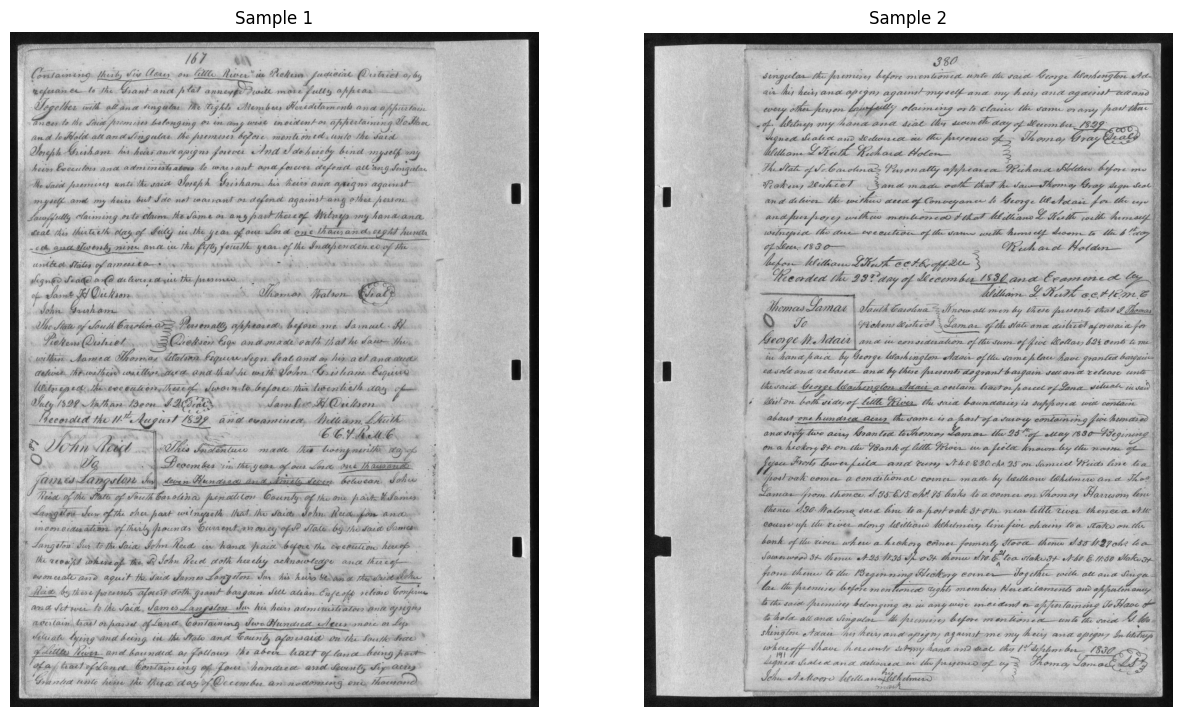

In [ ]:
# Analyze image sizes
image_sizes = []
for file in df_images['filename']:
    with Image.open(os.path.join(image_folder, file)) as img:
        image_sizes.append(img.size)

df_images['width'], df_images['height'] = zip(*image_sizes)

import matplotlib.pyplot as plt
from PIL import Image

# Display random samples of images
sample_files = df_images['filename'].sample(2)
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
for i, file in enumerate(sample_files):
    img = Image.open(os.path.join(image_folder, file))
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Sample {i+1}")
    axes[i].axis('off')
plt.show()

## Processing of Data using TrOCR Large Model

### Test for One Strip of Text

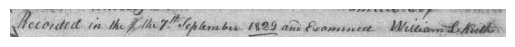

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

# Open an image file
img = Image.open('200PageSnip.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [19]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

# load image from the IAM database
url = '200PageSnip.png'
image = Image.open(url).convert("RGB")

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten')
pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_text

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

'Recorded in the film 7 September 1829 in Economics . William B. Keith'

Character-Level Accuracy: 77.37%
Word-Level Accuracy: 50.00%
BLEU Score: 13.44%


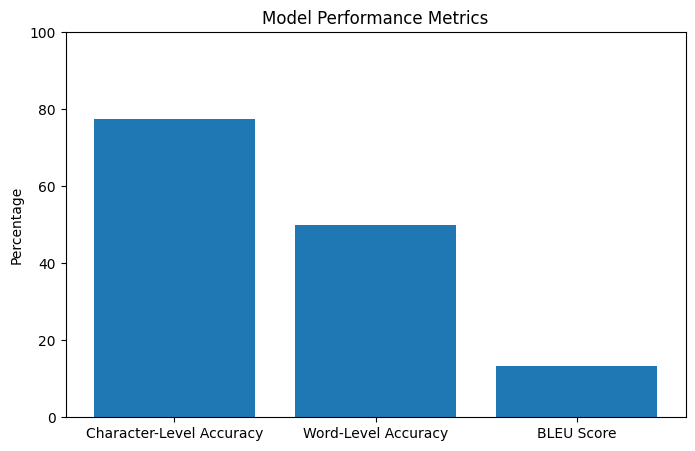

In [22]:
# Ground truth (actual text)
actual_text = """
Recorded in the the 7 September 1829 and Examined William L. Hilth
"""

# Utility functions
from difflib import SequenceMatcher
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

def calculate_character_level_accuracy(actual, predicted):
    return SequenceMatcher(None, actual, predicted).ratio()

def calculate_word_level_accuracy(actual, predicted):
    actual_words = actual.split()
    predicted_words = predicted.split()
    matches = sum(1 for aw, pw in zip(actual_words, predicted_words) if aw == pw)
    return matches / len(actual_words)

def calculate_bleu_score(actual, predicted):
    reference = [actual.split()]
    hypothesis = predicted.split()
    smoothing = SmoothingFunction().method1
    return sentence_bleu(reference, hypothesis, smoothing_function=smoothing)

# Calculate metrics
char_accuracy = calculate_character_level_accuracy(actual_text, generated_text)
word_accuracy = calculate_word_level_accuracy(actual_text, generated_text)
bleu_score = calculate_bleu_score(actual_text, generated_text)

# Print metrics
print(f"Character-Level Accuracy: {char_accuracy * 100:.2f}%")
print(f"Word-Level Accuracy: {word_accuracy * 100:.2f}%")
print(f"BLEU Score: {bleu_score * 100:.2f}%")

# Plot results
metrics = ["Character-Level Accuracy", "Word-Level Accuracy", "BLEU Score"]
values = [char_accuracy * 100, word_accuracy * 100, bleu_score * 100]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values)
plt.title("Model Performance Metrics")
plt.ylabel("Percentage")
plt.ylim(0, 100)
plt.show()


### Test for One Image

In [23]:
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import logging

# Define the folder containing images
input_folder = "output/processed_images/"
output_folder = "output/results/"

# Create output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Load the model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten')

# Function to split an image into lines
def split_image_into_lines(image_path, num_lines=41):
    try:
        image = Image.open(image_path)
        width, height = image.size
        line_height = height // num_lines
        lines = []
        for i in range(num_lines):
            top = i * line_height
            bottom = top + line_height if i < num_lines - 1 else height
            lines.append(image.crop((0, top, width, bottom)))
        return lines
    except Exception as e:
        return f"Error splitting image {image_path}: {e}"

# Function to perform OCR on an image line
def perform_ocr(image):
    try:
        pixel_values = processor(images=image.convert("RGB"), return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    except Exception as e:
        return f"Error during OCR: {e}"

# Function to configure a unique logger for each image
def setup_logger(log_file):
    logger = logging.getLogger(log_file)
    logger.setLevel(logging.INFO)
    # Remove existing handlers if any
    if logger.hasHandlers():
        logger.handlers.clear()
    # Add a file handler
    handler = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger

# Main processing loop
try:
    for file_name in os.listdir(input_folder):
        if file_name.endswith("dupickens_a-1_200_enhanced.png"):
            file_path = os.path.join(input_folder, file_name)
            
            # Define output file paths
            image_output_folder = os.path.join(output_folder, file_name.replace(".png", ""))
            os.makedirs(image_output_folder, exist_ok=True)

            ocr_output_file = os.path.join(image_output_folder, "ocr_output.txt")
            log_file = os.path.join(image_output_folder, "process_log.txt")
            
            # Setup logger specific for this image
            logger = setup_logger(log_file)

            logger.info(f"Started processing {file_name}")
            
            with open(ocr_output_file, 'w') as ocr_out:
                # Split image into lines
                lines = split_image_into_lines(file_path)
                if isinstance(lines, str):  # Check if an error occurred
                    logger.error(lines)
                    continue
                
                # Perform OCR for each line
                for i, line in enumerate(lines):
                    text = perform_ocr(line)
                    if isinstance(text, str) and text.startswith("Error"):
                        logger.error(f"Line {i + 1}: {text}")
                    else:
                        ocr_out.write(f"Line {i + 1}: {text}\n")
            
            logger.info(f"Finished processing {file_name}")
except Exception as e:
    print(f"Error occurred: {e}")
finally:
    print("Processing complete.")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod

Processing complete.


In [24]:
with open("output/results/dupickens_a-1_200_enhanced/ocr_output.txt", "r") as file:
    print(file.read())

Line 1: 1940som
Line 2: ITFTON WITH
Line 3: spipes from the heavy building has been transferred to
Line 4: and farmers defend all and higher and Supervisor while the Lord Richard Thomas
Line 5: What he has happens against myself times . Among Against every decades .
Line 6: Generally bluxness the home or any part time of Welwyn my hands and
Line 7: I feel much before in the year of a man ( It is higher tender and adverse
Line 8: in the payments of my own way to former themselves .
Line 9: Highboard base farmers the handling was a number of a number of
Line 10: Walesfahrett has shown before six the interesting charter Personally known .
Line 11: Various Project General board the base district and service with
Line 12: What he has been confused and welcome as his met more accepted
Line 13: in conference trade . In Fashion's largest trial there is the Results was a fundraising ,
Line 14: people known to handsome down to cause husbands to settle households .
Line 15: Cigadier Welming Westc

### Run for all Images

In [28]:
import os
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import logging

# Define the folder containing images
input_folder = "output/processed_images/"
output_folder = "output/results/"

# Create output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Load the model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-handwritten')

# Function to split an image into lines
def split_image_into_lines(image_path, num_lines=41):
    try:
        image = Image.open(image_path)
        width, height = image.size
        line_height = height // num_lines
        lines = []
        for i in range(num_lines):
            top = i * line_height
            bottom = top + line_height if i < num_lines - 1 else height
            lines.append(image.crop((0, top, width, bottom)))
        return lines
    except Exception as e:
        return f"Error splitting image {image_path}: {e}"

# Function to perform OCR on an image line
def perform_ocr(image):
    try:
        pixel_values = processor(images=image.convert("RGB"), return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    except Exception as e:
        return f"Error during OCR: {e}"

# Function to configure a unique logger for each image
def setup_logger(log_file):
    logger = logging.getLogger(log_file)
    logger.setLevel(logging.INFO)
    # Remove existing handlers if any
    if logger.hasHandlers():
        logger.handlers.clear()
    # Add a file handler
    handler = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger

# Main processing loop
try:
    for file_name in os.listdir(input_folder):
        if file_name.endswith("_enhanced.png"):
            file_path = os.path.join(input_folder, file_name)
            
            # Define output file paths
            image_output_folder = os.path.join(output_folder, file_name.replace(".png", ""))
            os.makedirs(image_output_folder, exist_ok=True)

            ocr_output_file = os.path.join(image_output_folder, "ocr_output.txt")
            log_file = os.path.join(image_output_folder, "process_log.txt")
            
            # Setup logger specific for this image
            logger = setup_logger(log_file)

            logger.info(f"Started processing {file_name}")
            
            with open(ocr_output_file, 'w') as ocr_out:
                # Split image into lines
                lines = split_image_into_lines(file_path)
                if isinstance(lines, str):  # Check if an error occurred
                    logger.error(lines)
                    continue
                
                # Perform OCR for each line
                for i, line in enumerate(lines):
                    text = perform_ocr(line)
                    if isinstance(text, str) and text.startswith("Error"):
                        logger.error(f"Line {i + 1}: {text}")
                    else:
                        ocr_out.write(f"Line {i + 1}: {text}\n")
            
            logger.info(f"Finished processing {file_name}")
except Exception as e:
    print(f"Error occurred: {e}")
finally:
    print("Processing complete.")


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decod